In [1]:
from dl import authClient as ac, queryClient as qc, storeClient as sc, helpers
import pylab as plt
import numpy as np
from astropy.io import fits
import matplotlib as mpl
import math
import astropy.io.fits as fits
from astropy.table import Table 

In [2]:
token=ac.login('mgkadrmas')

In [3]:
def roi_cut(xcut,ycut,x,y):
    """
    xcut : numpy array
         Array of x-values for the cut
    ycut : numpy array
         Array of y-values for the cut
    x : numpy array or list
         Array of x-values that should be cut
    y : numpy array or list
         Array of y-values that should be cut

    Returns
    ind : numpy array
       The indices of values OUTSIDE the cut
    cutind : 
       The indices of values INSIDE the cut

    """

    from matplotlib.path import Path
    tupVerts = list(zip(xcut,ycut))
    points = np.vstack((x,y)).T
    p = Path(tupVerts) # make a polygon
    inside = p.contains_points(points)
    ind, = np.where(~inside)
    cutind, = np.where(inside)

    return ind, cutind

In [9]:
def SMCParallax (ra,dec,radius):
    res=qc.query(token,sql='select * from gaia_dr2.gaia_source where q3c_radial_query(ra,dec,'+str(ra)+','+str(dec)+','+str(radius)+')')
    df=helpers.utils.convert(res,'table') ##take query
    xcut=[0.463849,0.712431,1.019504,1.458179,1.867609,2.554867,3.198257,2.788827,2.072324,1.765252,1.443557,1.253464,0.990259,0.727054,0.478471]
    ycut=[19.267857,18.375000,17.452381,15.875000,15.309524,15.279762,15.875000,16.470238,16.321429,17.035714,18.255952,19.386905,20.220238,20.428571,19.595238]
    x=df['bp_rp']
    y=df['phot_g_mean_mag']
    (ind, cutind) = roi_cut(xcut,ycut,x,y) 
    df=df[cutind] #only data inside of the polygon!!
    medpmra=np.nanmedian(df['pmra'])
    medpmdec=np.nanmedian(df['pmdec'])
    pndist=np.sqrt((df['pmra']-medpmra)**2 + (df['pmdec']-medpmdec)**2)
    good= (np.abs(df['parallax'])<=0.2) & (pndist<=2.0)
    newoffset=0.021026353578574002
    medplx=np.nanmedian(df['parallax'][good]) + newoffset 
    ngood=np.sum(good)
    Sd= (1/ngood)*math.sqrt(sum((medplx-(df['parallax'][good]))**2)) #standard deviation of mean
    sigma= (1/ngood)*np.sqrt(np.nansum(df['parallax_error']**2)) #standard error of parallax
    print(ra, dec, medplx)
    return (ngood, medplx, Sd, sigma)
    

In [23]:
radius=0.5
dtype = np.dtype([('ra',float),('dec',float),('radius',float),('ngood',int),('parallax',float),('Sd',float),('sigma',float)])
cat = np.zeros([27,9],dtype=dtype)
for i in range (27):
    ra=i
    for j in range (9):
        dec=j-77
        (ngood, medplx, Sd, sigma) = SMCParallax(ra,dec,radius) 
        cat[i,j]['ra']=ra
        cat[i,j]['dec']=dec
        cat[i,j]['radius']=radius
        cat[i,j]['ngood']=ngood
        cat[i,j]['parallax']=medplx
        cat[i,j]['Sd']=Sd
        cat[i,j]['sigma']=sigma
        
acat = Table(cat)
acat.write('SMCParallax2.fits', format='fits')

/data0/sw/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)


0 -77 0.0530108611544922
0 -76 0.038742368528125556
0 -75 0.031182480431323753
0 -74 0.0372719839494186
0 -73 0.0295287537877912
0 -72 0.0468070274987423
0 -71 0.031712616460450004
0 -70 0.031059786629451802
0 -69 0.05215341774828271
1 -77 0.068776336922737
1 -76 0.023378399126957602
1 -75 0.020460435738490403
1 -74 0.0233023349120131
1 -73 0.0202789540291717
1 -72 0.036694805206688955
1 -71 0.032594751541349956
1 -70 0.0275035233595554
1 -69 0.05463435879357541
2 -77 0.0790465173158401
2 -76 0.012347378440275203
2 -75 0.023228739819461202
2 -74 0.022702119715020053
2 -73 0.021355230003377454
2 -72 0.03406837473541635
2 -71 0.035459608629930604
2 -70 0.012745456265366202
2 -69 0.026861254253608503
3 -77 0.057555450614553805
3 -76 0.015298634673472002
3 -75 0.021462378081483303
3 -74 0.020970713788312702
3 -73 0.0170992787297541
3 -72 0.028746729302563702
3 -71 0.0301735409117036
3 -70 0.021495773218689302
3 -69 0.023048606521404103
4 -77 0.034351895460798004
4 -76 0.020333623335257203


In [26]:
acat=fits.getdata('SMCParallax2.fits')

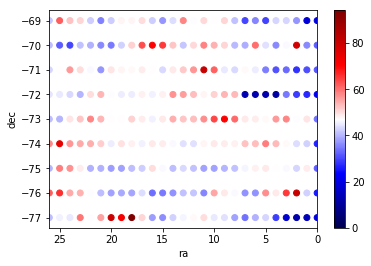

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('ra')
ax.set_ylabel('dec')
ax.set_xlim([26,0])
sc = ax.scatter(acat['ra'],acat['dec'],c=1/acat['parallax'], vmin=0, cmap=plt.cm.seismic)
fig.colorbar(sc)

In [32]:
dists=1/acat['parallax']
distavg=np.mean(dists)
print(distavg) ### accepted value is 60 

45.80042352971275
